# 결정트리, 랜덤 포레스트, 부스팅 - 회귀모델

## 문제: 기대수명 예측 (회귀)

- WHO가 제공하는 국가별/연도별 건강, 교육, 경제 데이터를 기반으로 기대 수명을 예측
- 193개국, 15년간 관측한 데이터 (2000~2015), 20개의 특성 (feature) 사용

## import 

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from warnings import filterwarnings
filterwarnings('ignore')
%config InlineBackend.figure_format="retina"
matplotlib.rcParams['figure.figsize'] = (6,4)
matplotlib.rcParams.update({'font.size': 13})

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC, SVR
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn import tree
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, KFold, cross_val_score
# from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
# from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.metrics import mean_squared_error, r2_score               
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
# from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

## 데이터

- Life Expectancy (WHO)
- 데이터 (2938,22)
- 결측치가 많은 샘플은 제외하겠다

In [3]:
## 데이터 다운로드와 결측치 확인

data = pd.read_csv("https://raw.githubusercontent.com/StillWork/data/master/Life%20Expectancy%20Data.csv")
print(data.shape)

# 결측치 확인
data.isnull().sum()

(2938, 22)


Country                              0
Year                                 0
Status                               0
Life expectancy                     10
Adult Mortality                     10
infant deaths                        0
Alcohol                            194
percentage expenditure               0
Hepatitis B                        553
Measles                              0
 BMI                                34
under-five deaths                    0
Polio                               19
Total expenditure                  226
Diphtheria                          19
 HIV/AIDS                            0
GDP                                448
Population                         652
 thinness  1-19 years               34
 thinness 5-9 years                 34
Income composition of resources    167
Schooling                          163
dtype: int64

- 여기서는 편의상 결측치가 있는 샘플을 모두 삭제하겠다

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10   BMI                             2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

In [5]:
# 특성중에 결측치가 하나라도 있는 샘플을 모두 삭제
df = data.dropna()

# 카테고리 변수 Status 인코딩
print(df.Status.value_counts())
df.Status = df.Status.map({"Developing":0, "Developed":1})
print(df.shape)
df[:4]

Developing    1407
Developed      242
Name: Status, dtype: int64
(1649, 22)


,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,0,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,0,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,0,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,0,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8


In [8]:
df[:4].T

,0,1,2,3
Country,Afghanistan,Afghanistan,Afghanistan,Afghanistan
Year,2015,2014,2013,2012
Status,0,0,0,0
Life expectancy,65.0,59.9,59.9,59.5
Adult Mortality,263.0,271.0,268.0,272.0
infant deaths,62,64,66,69
Alcohol,0.01,0.01,0.01,0.01
percentage expenditure,71.279624,73.523582,73.219243,78.184215
Hepatitis B,65.0,62.0,64.0,67.0
Measles,1154,492,430,2787


# 데이터 탐색 

## 확률 분포

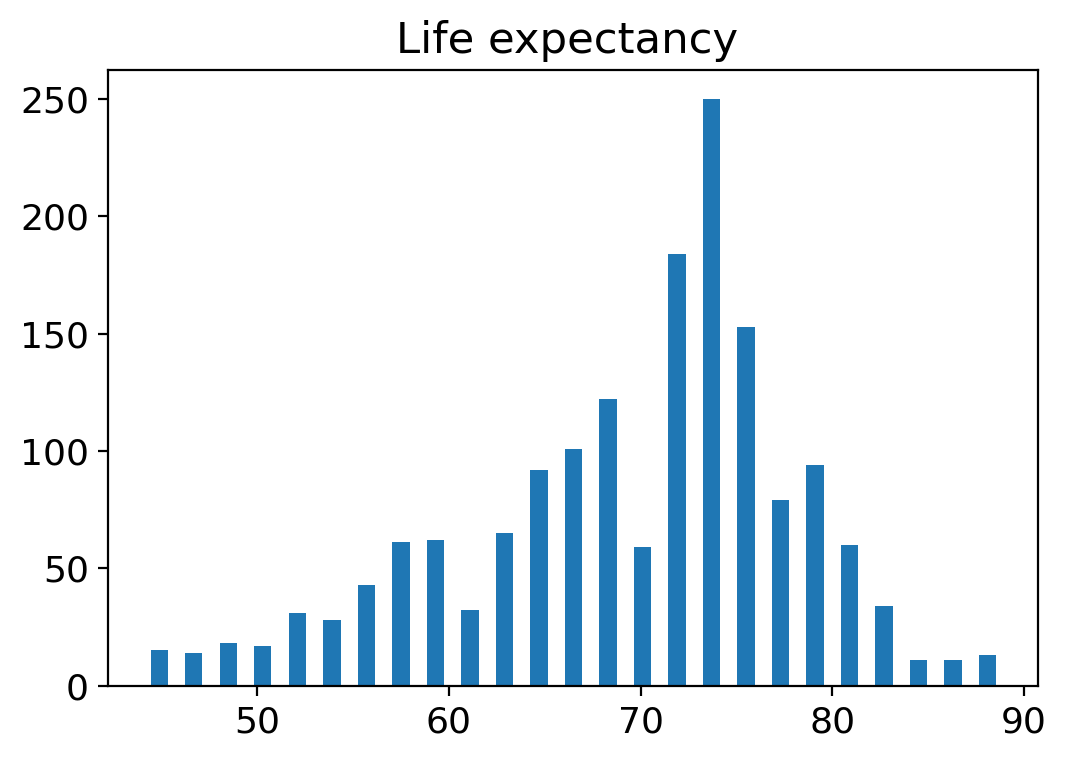

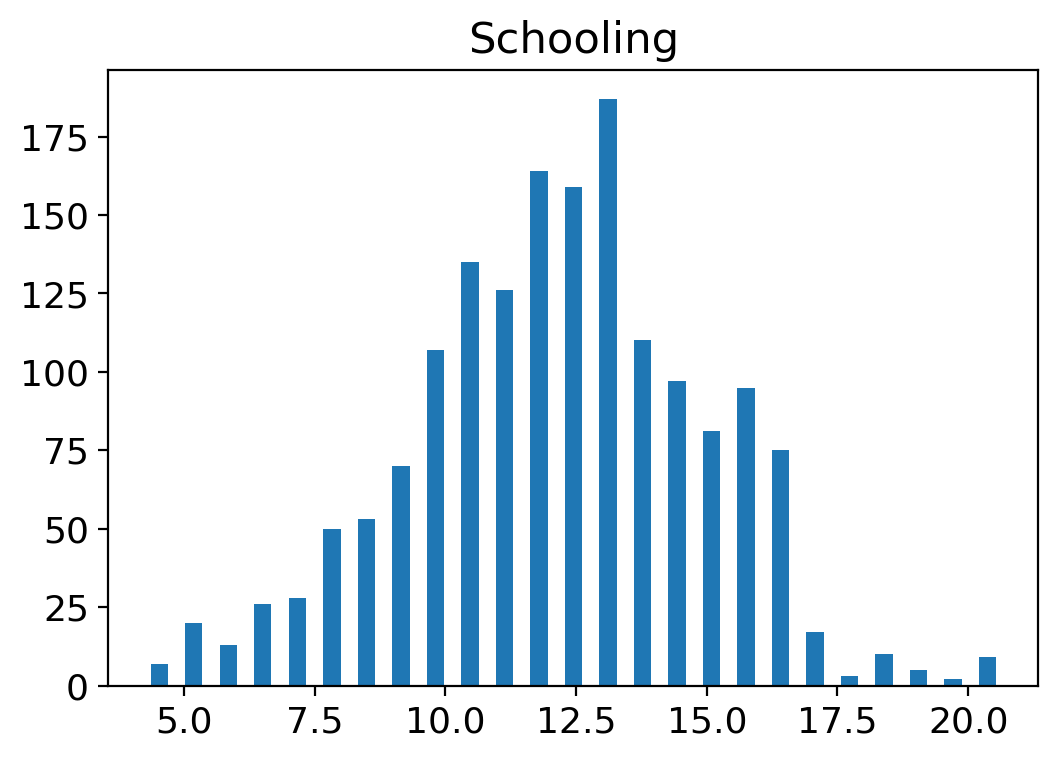

In [9]:
for col in ['Life expectancy ',"Schooling"]:
    plt.hist(df[col], bins=25, rwidth=0.5)
    plt.title(col)
    plt.show()

## 산포도

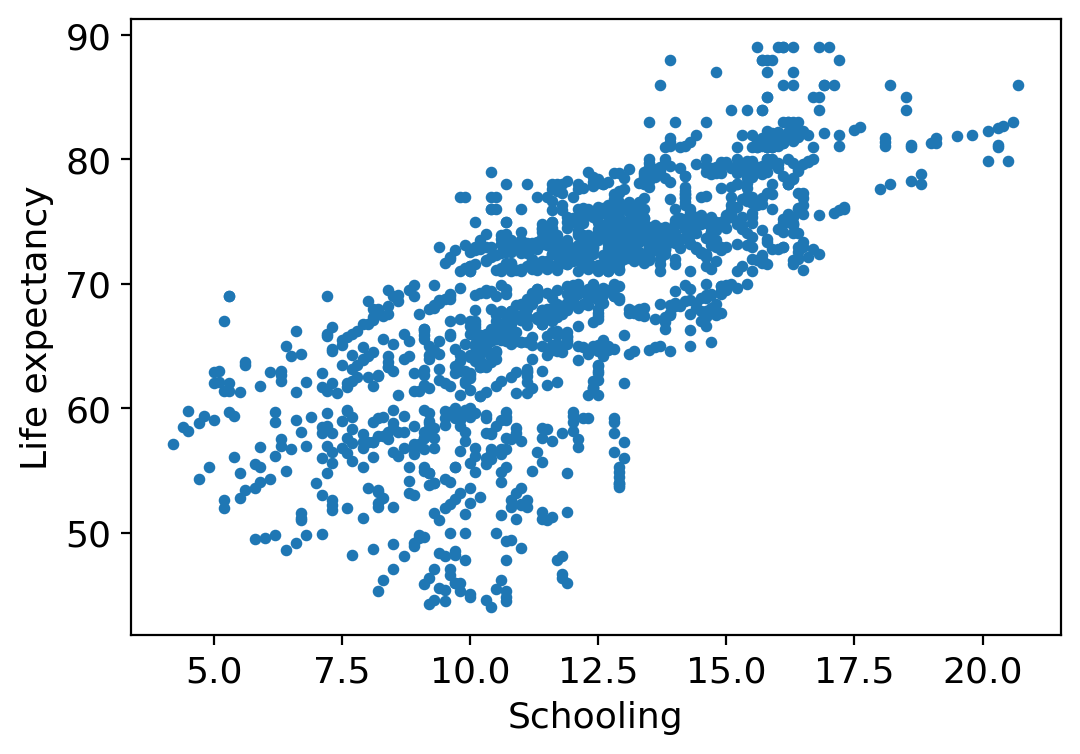

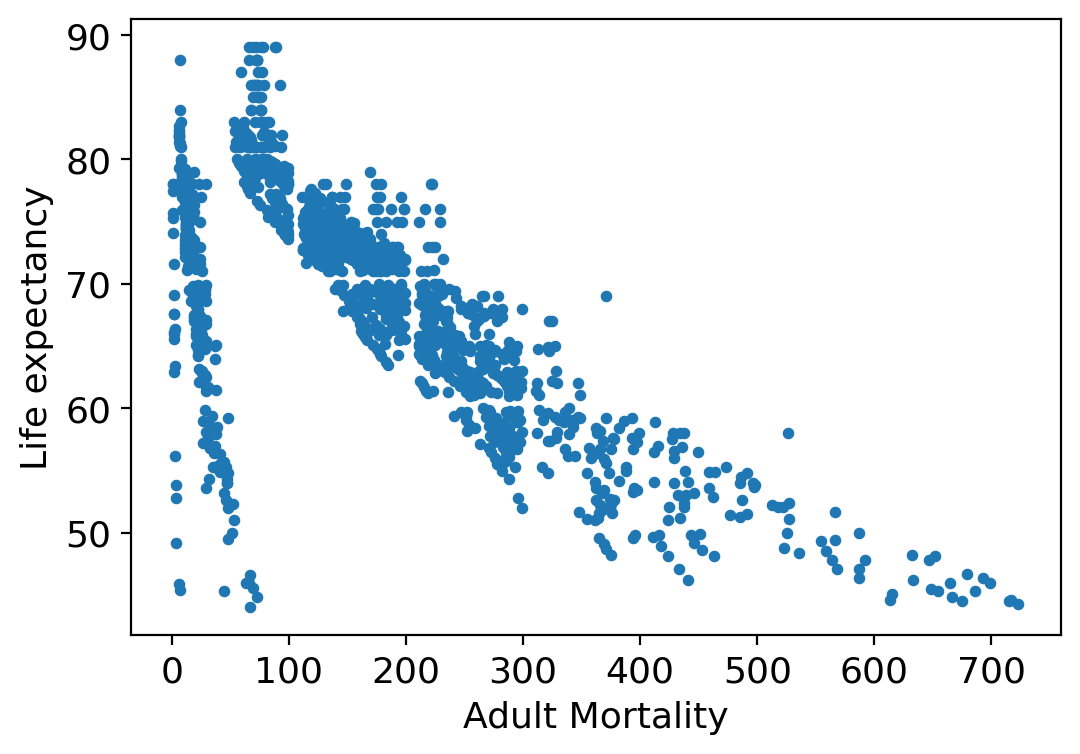

In [10]:
for col in ["Schooling", 'Adult Mortality']:
    plt.scatter(df[col] , df['Life expectancy '], s=10)
    plt.ylabel('Life expectancy')
    plt.xlabel(col)
    plt.show()

## 회귀 모델 성능 평가
- 회귀 모델의 성능을 평가하는 척도로 기본적으로 R-Squared를 사용하며 MAE, RMSE 등을 참고로 본다
 - MAE: mean absolute error  
 - MSE: mean squared error    
 - RMSE: root MSE  

$MAE = $$1\over{N}$$ \sum |y_{i} - \hat{y}|$

$MSE = $$1\over{N}$$ \sum (y_{i} - \hat{y})^{2}$

$RMSE = \sqrt{MSE}$

$R^{2} = 1$-$\sum(y_{i}-\hat{y})^{2}\over{\sum(y_{i}-\bar{y})^{2}}$ $= 1$-$MSE\over{Variance}$  
 >  $y$ :  실제값, $\hat{y}$ :  예측치, $\bar{y}$ :  평균치
 
-  R-Squared
 - 회귀 성능의 기본적인 평가 지표
 - MSE를 분산으로 정규화한 값을 사용한다
 - R-sqaured 값은 1에 가까울수록 완벽한 예측을 수행한 것이고, 0 근처이면 오차 평균치가 표준편차 정도인 경우이다

In [11]:
## 회귀 모델의 성능 평가 지표

# Maximum Error
# MAE: mean absolute error
# RMSE: root MSE
# R-Squared

def show_reg_result(y_test,y_pred):
    print("Max Error: ", 
      round(np.abs(y_test - y_pred).max(),3))
    print("Mean Absolute Error: ", 
      round(np.abs(y_test-y_pred).mean(),3))
    print("Root Mean Squared Error: ", 
      mean_squared_error(y_test,y_pred, squared=False).round(3))
    print("R-Squared: ", 
      r2_score(y_test, y_pred).round(3))

# 선형회귀 모델

- 다중 선형회귀 모델 (모든 특성을 사용한다)
- 스케일링이 필요하다

In [12]:
features = df.columns.difference(['Country','Life expectancy '])
X = df[features]
y = df["Life expectancy "]

# 스케일링을 수행할 데이터프레임
X_sc = X.copy()
scaler = StandardScaler()

# 컬럼과 인덱스를 보기 위해서 데이터프레임을 유지
X_sc.loc[:][:] = scaler.fit_transform(X_sc)

X_train, X_test, y_train, y_test = train_test_split(X_sc, y, random_state=9)

In [13]:
X_train[:5]

,BMI,HIV/AIDS,thinness 1-19 years,thinness 5-9 years,Adult Mortality,Alcohol,Diphtheria,GDP,Hepatitis B,Income composition of resources,Measles,Polio,Population,Schooling,Status,Total expenditure,Year,infant deaths,percentage expenditure,under-five deaths
2060,1.011298,-0.312389,-0.902737,-0.947428,-0.640327,1.915806,0.641774,1.479428,0.694705,0.985880,5,0.598626,-0.207809,1.388461,1,-1.964566,2010,0,1.376234,0
276,-0.740755,-0.096819,0.597969,0.557189,0.660838,-0.777860,-0.424391,-0.413173,-0.164774,-0.970049,426,-0.292491,-0.206689,-0.830151,0,-0.254895,2011,25,-0.334742,39
1493,-0.634417,-0.129983,0.467473,0.428222,0.740664,-1.122948,-3.530176,-0.448961,-2.782279,-1.177662,43,-3.366843,-0.148668,-0.901719,0,-2.073324,2012,9,-0.370089,12
581,0.813812,-0.312389,-0.576497,-0.625010,-1.223057,-0.062859,0.178224,-0.430631,0.343100,0.346652,0,0.197624,-0.142843,0.243371,0,0.349797,2010,12,-0.333048,15
2036,-0.983815,-0.312389,-0.837489,1.030069,0.421359,-0.028102,-0.238971,-0.485020,-1.453993,-0.035793,7003,-0.292491,-0.196483,-0.257606,0,-1.377275,2002,68,-0.397382,89


In [14]:
# 모델 학습 및 성능 보기 (R-squared)
lin = LinearRegression()
lin.fit(X_train, y_train)
lin.score(X_test, y_test)

0.8319402539203493

## 선형 모델 가중치

In [15]:
# 선형모델 특성 가중치 
lin.coef_

array([ 7.86139599e-01, -2.61332089e+00, -1.74617734e-01, -2.56445947e-02,
       -2.04473274e+00, -6.51969633e-01,  2.26292664e-01,  2.01785959e-01,
       -8.59880859e-02,  2.04908580e+00, -9.60547699e-06,  2.27275720e-01,
       -5.76185940e-02,  2.47605449e+00,  7.41135306e-01,  3.07393884e-01,
       -1.34243248e-01,  9.48636761e-02,  6.00983309e-01, -7.10961162e-02])

In [16]:
# 특성 가중치 보기

def plot_feature_weight(feature, weight):
    plt.figure(figsize=(5,8))
    W = pd.DataFrame({'feature':feature,'weight':weight})
    W.sort_values('weight', inplace=True)
    plt.barh(W.feature, W.weight)

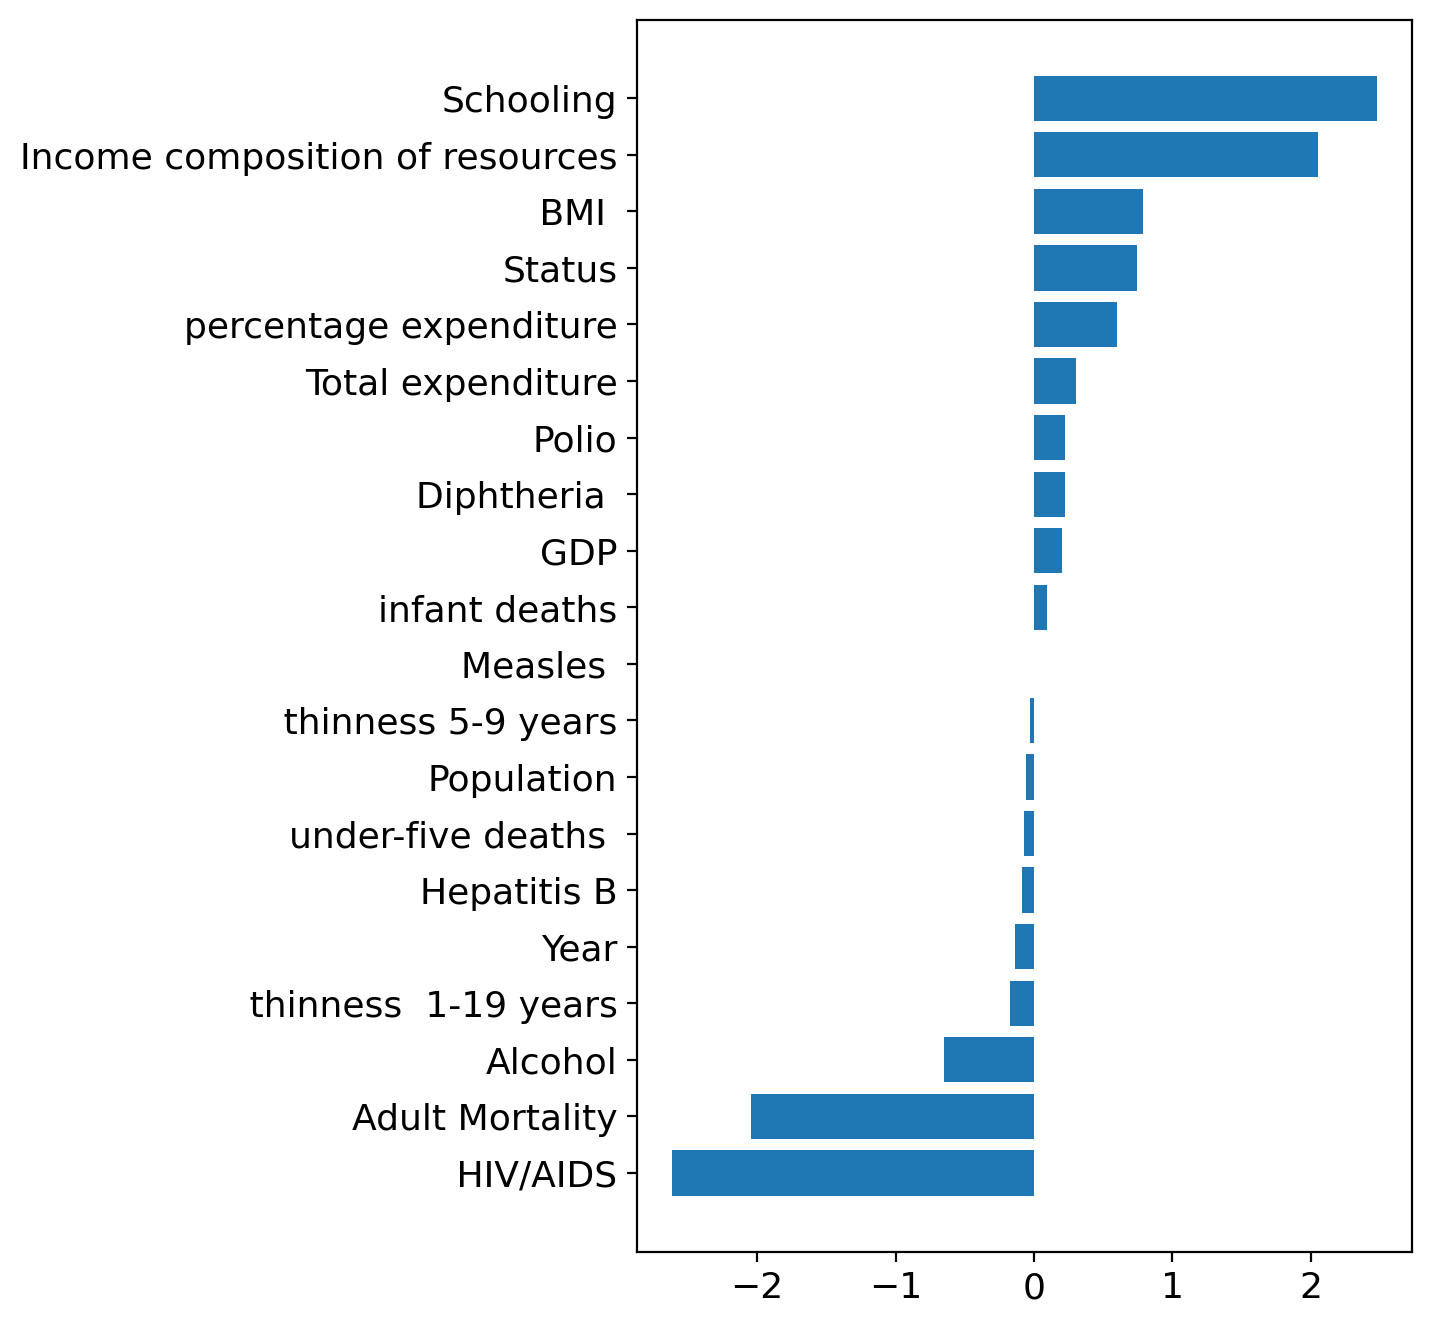

In [17]:
plot_feature_weight(X.columns,lin.coef_)

In [18]:
y_pred = lin.predict(X_test)
show_reg_result(y_test,y_pred)

Max Error:  12.46
Mean Absolute Error:  2.85
Root Mean Squared Error:  3.659
R-Squared:  0.832


# 결정트리 회귀 모델

- 결정트리를 회귀모델에 사용할 때는 나누어지는 하위 두 그룹의 분산이 가능한 작아지도록 나눈다
 - 즉, 목적변수의 값의 분포가 가능한 비슷한 샘플들끼리 모이도록 나눈다|

In [19]:
## 훈련 데이터와 검증 데이터 준비
# 스케일링하지 않은 데이터를 사용하겠다
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=9)

depth:  24 , R-squared:  0.922


<Axes: xlabel='depth'>

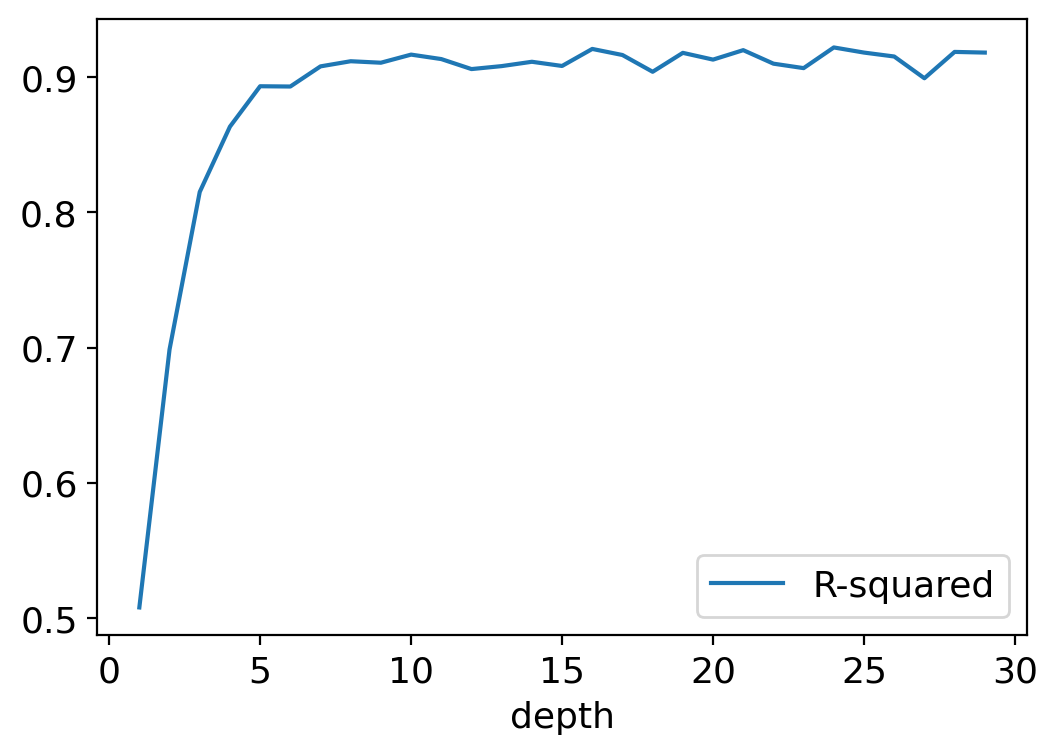

In [20]:
# 최적의 트리 깊이 (max_depth)를 실험으로 찾는다
res = []
for depth in range(1,30):
    dtr = DecisionTreeRegressor(max_depth=depth) 
    dtr.fit(X_train, y_train) 
    res.append((depth, dtr.score(X_test, y_test).round(4))) 

df_res = pd.DataFrame(res, columns=['depth','R-squared']).set_index('depth')
print('depth: ',df_res.idxmax()[0], ', R-squared: ',df_res.max()[0])
df_res.plot()

Max Error:  12.8
Mean Absolute Error:  1.645
Root Mean Squared Error:  2.686
R-Squared:  0.909


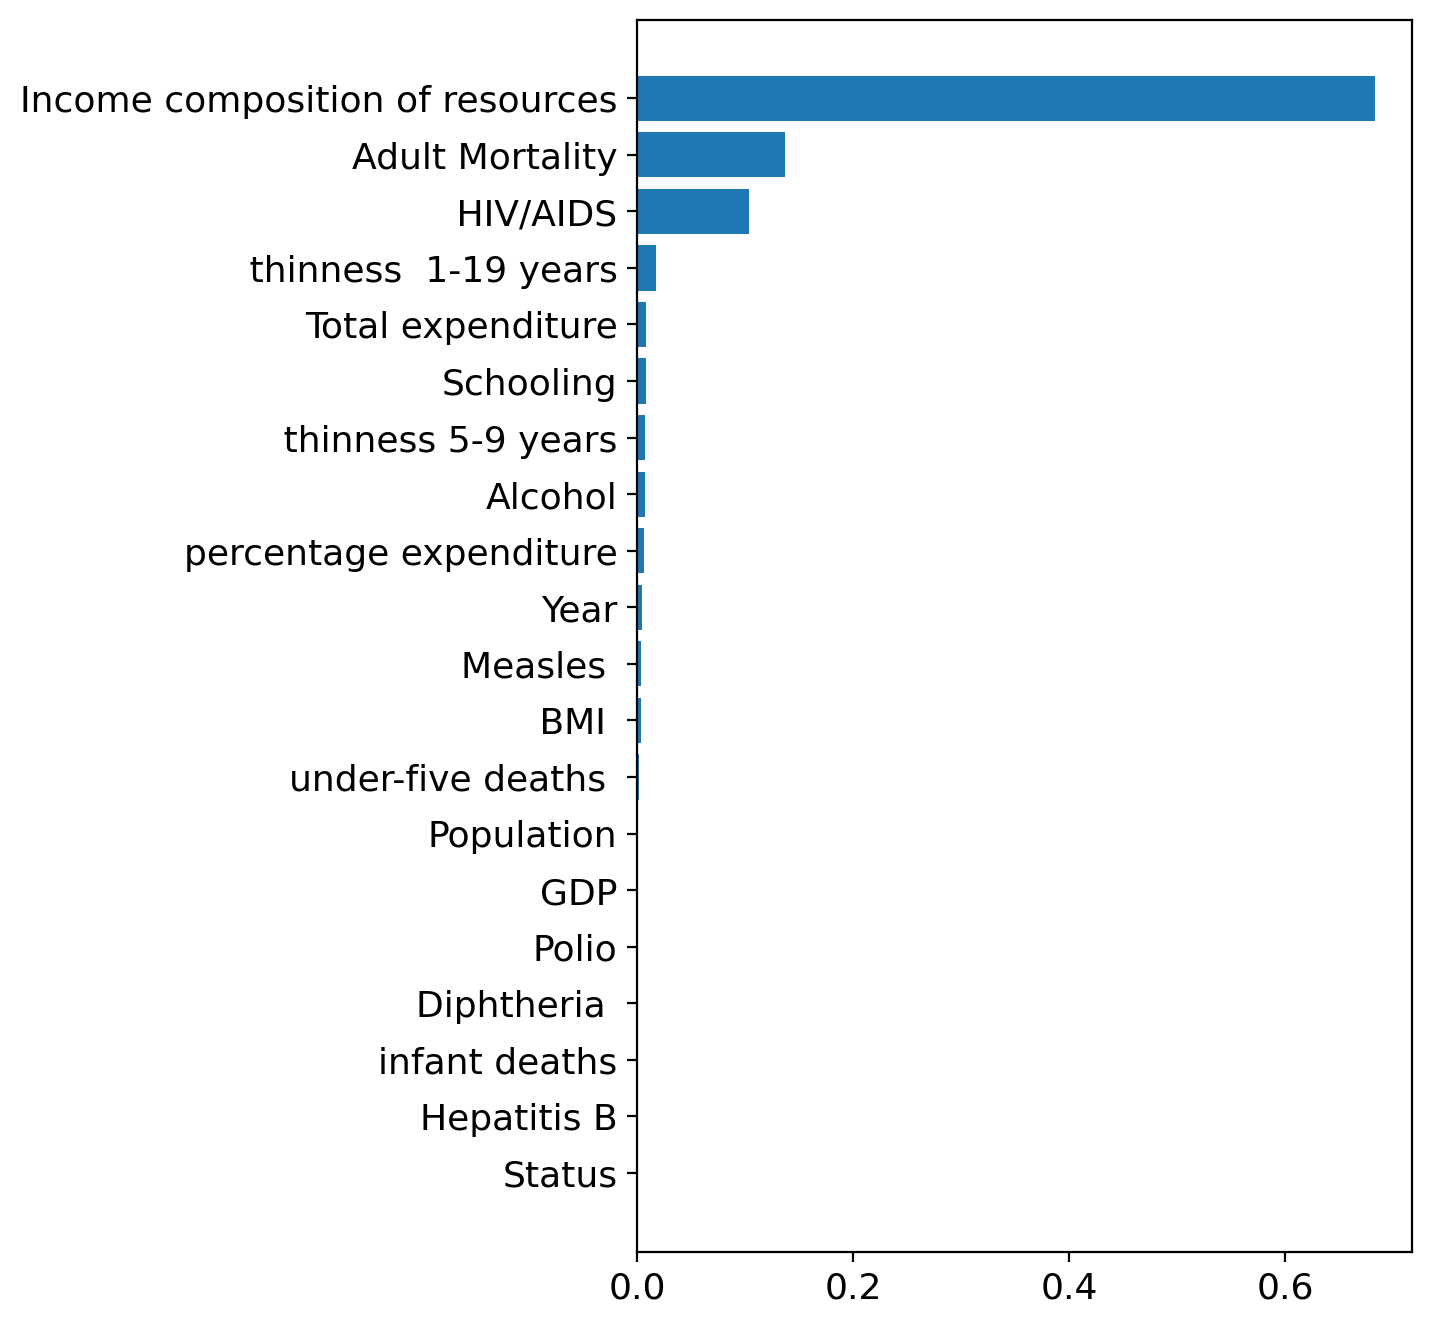

In [21]:
## 최적 결정 트리모델 성능 확인

dtr = DecisionTreeRegressor(max_depth=11)
dtr.fit(X_train, y_train)
y_pred = dtr.predict(X_test)
show_reg_result(y_test,y_pred)

plot_feature_weight(X.columns, dtr.feature_importances_)

## 결정트리 보기

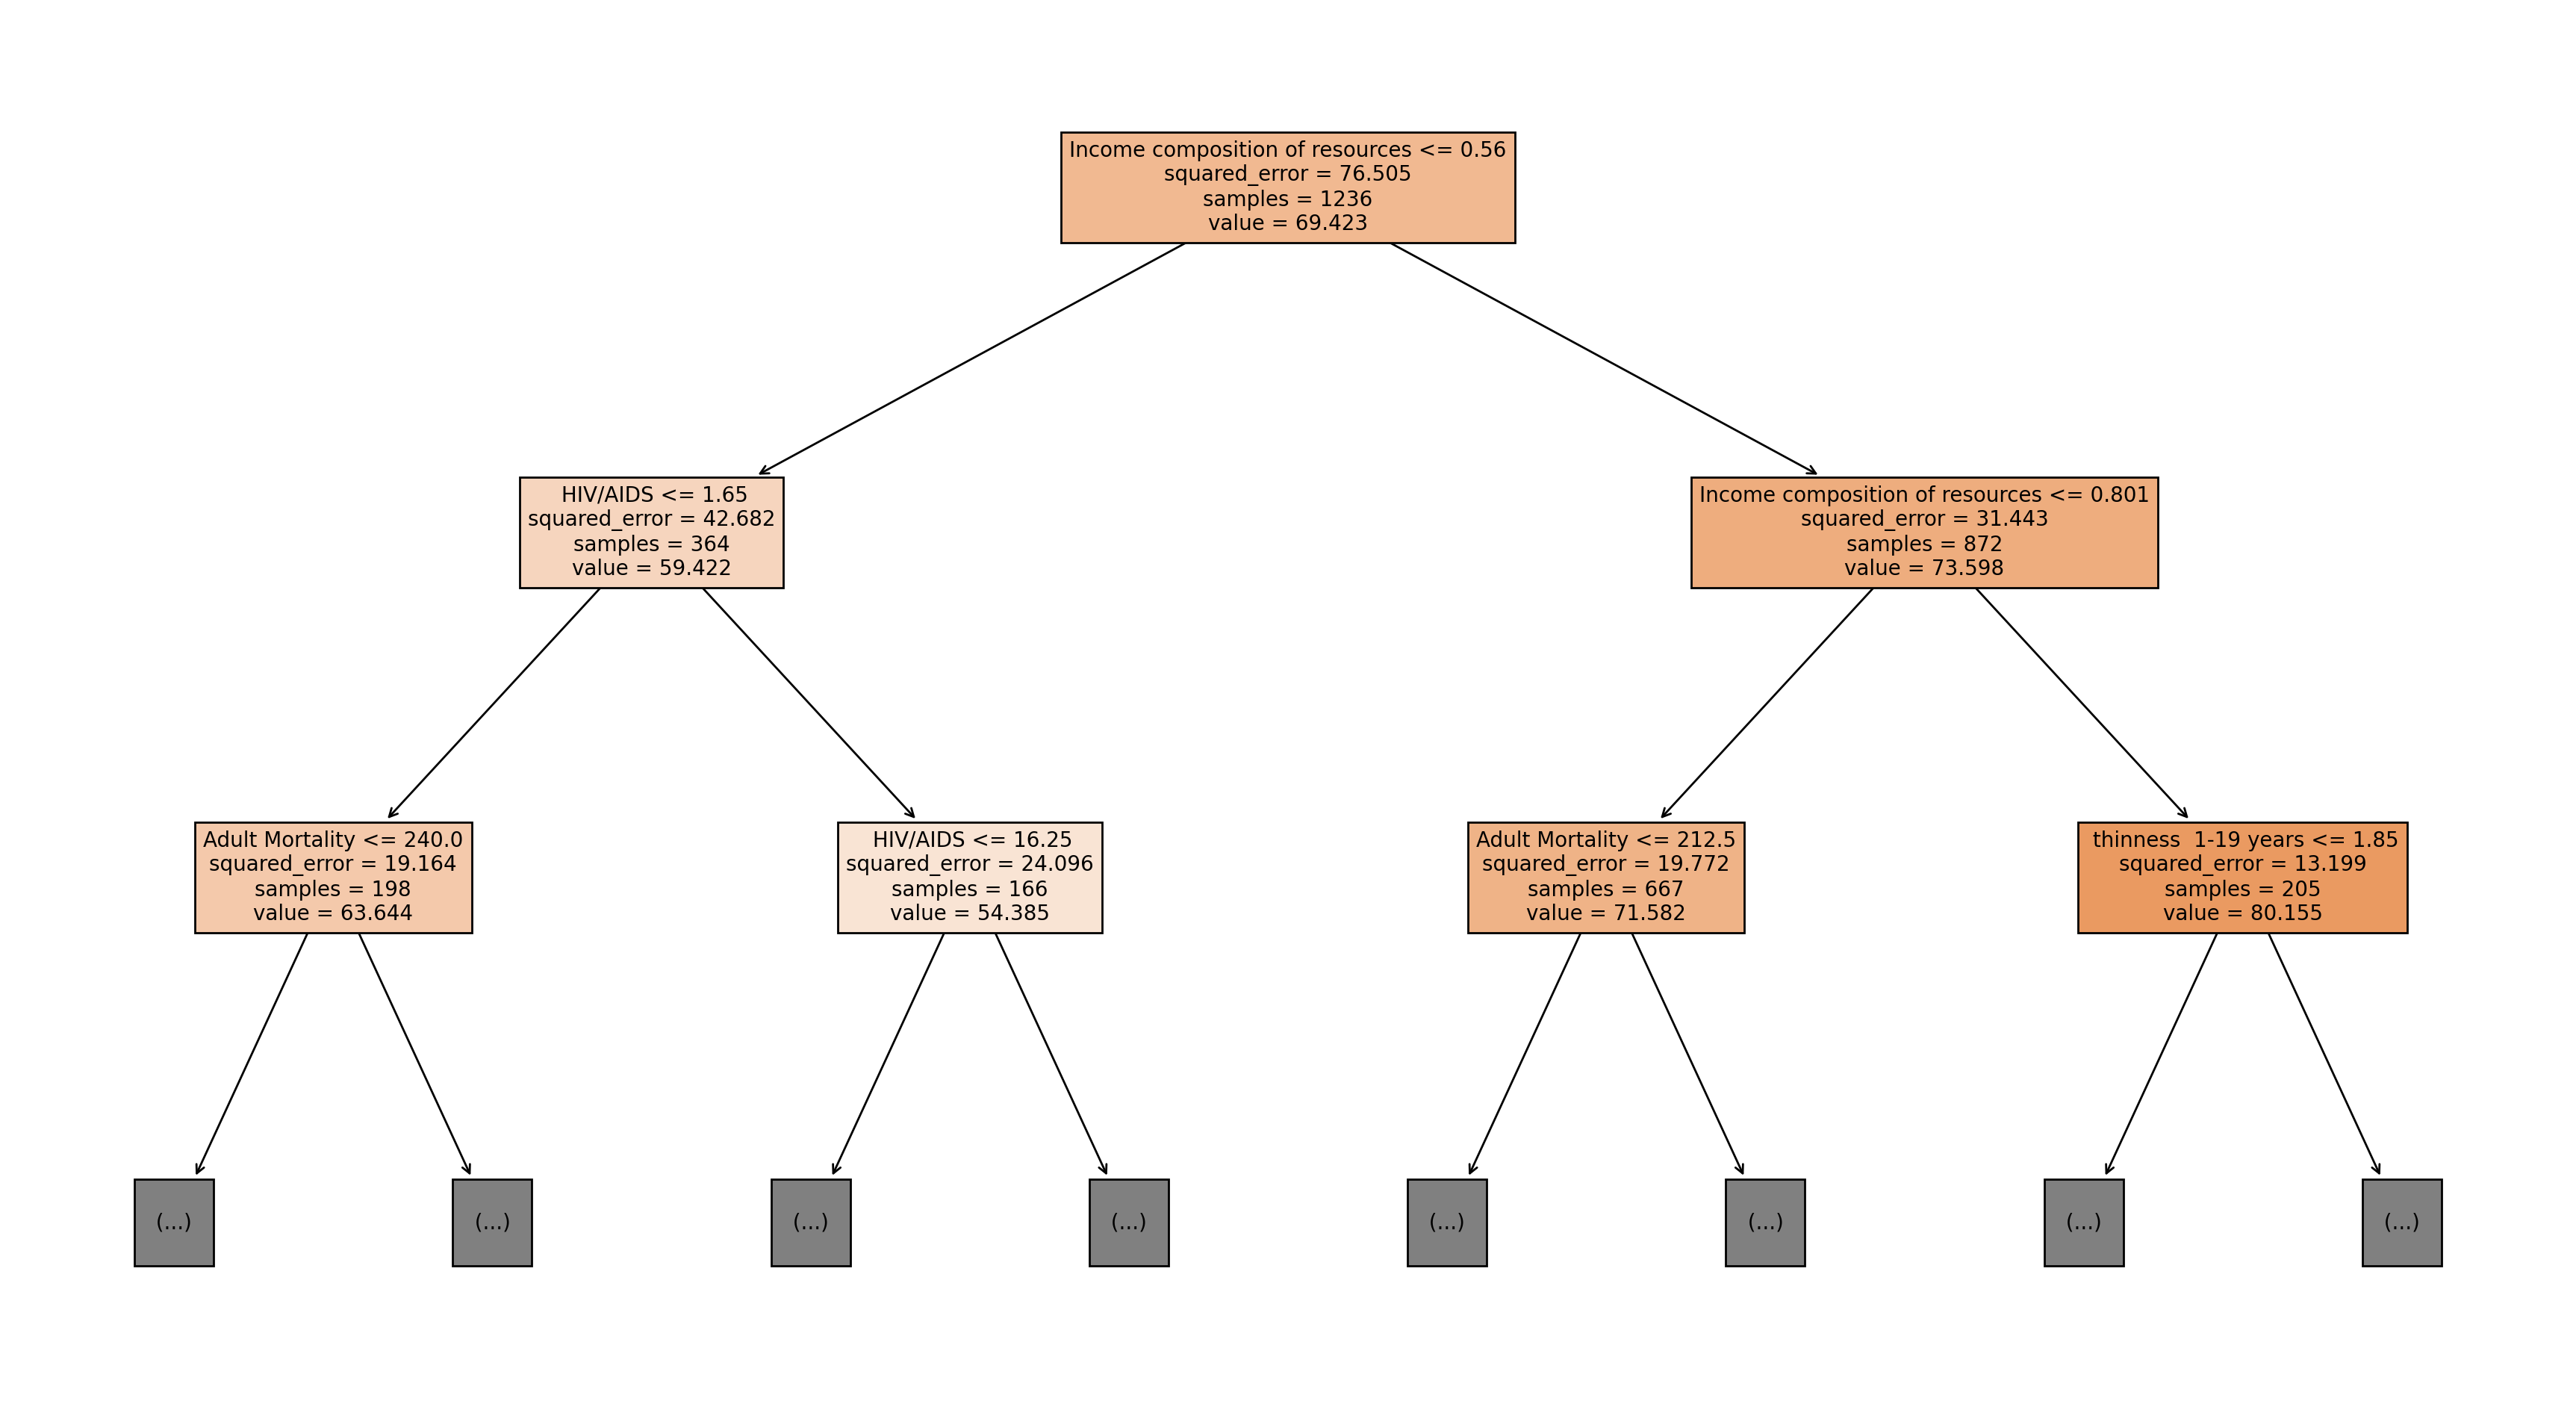

In [22]:
## 결정트리 그리기

plt.figure(figsize=(22,12))

tree.plot_tree(dtr, fontsize=10,
              feature_names=X.columns,
              filled=True,
              impurity=True,
              max_depth=2)
plt.show()

# 랜덤 포레스트 회귀 모델

depth:  27 , R-squared:  0.9548


<Axes: xlabel='depth'>

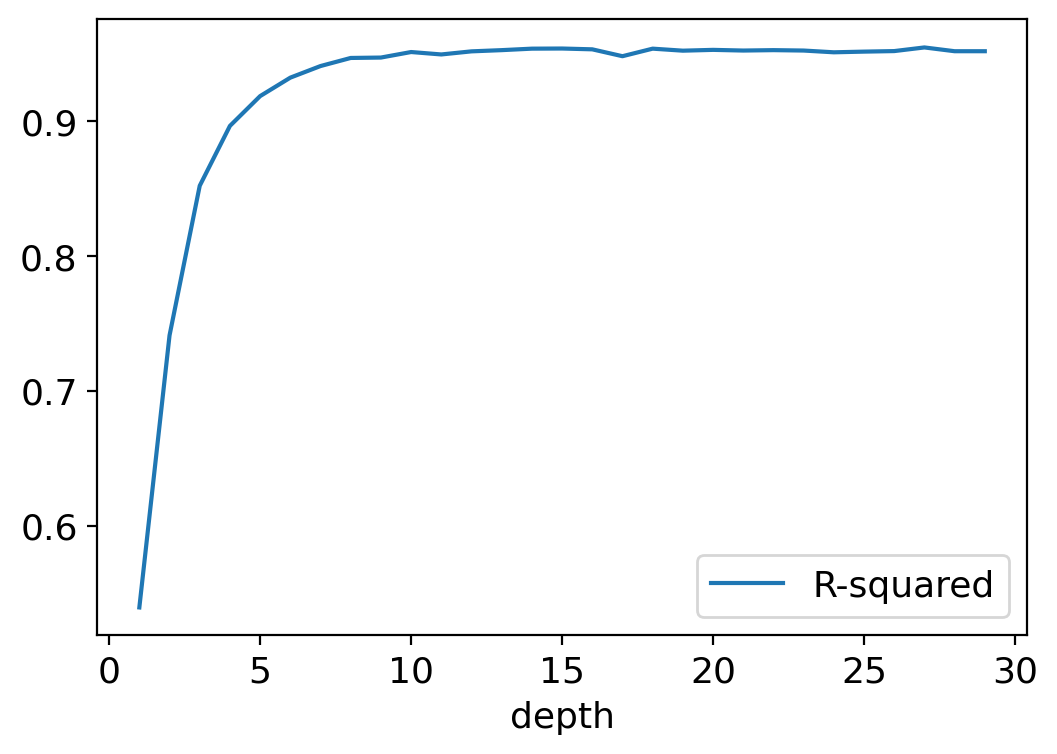

In [23]:
# 최적의 트리 깊이 (max_depth)를 실험으로 찾는다
res = []
for depth in range(1,30):
    rfr = RandomForestRegressor(max_depth=depth) 
    rfr.fit(X_train, y_train) 
    res.append((depth, rfr.score(X_test, y_test).round(4))) 

df_res = pd.DataFrame(res, columns=['depth','R-squared']).set_index('depth')
print('depth: ',df_res.idxmax()[0], ', R-squared: ',df_res.max()[0])
df_res.plot()

Max Error:  9.815
Mean Absolute Error:  1.24
Root Mean Squared Error:  1.937
R-Squared:  0.953


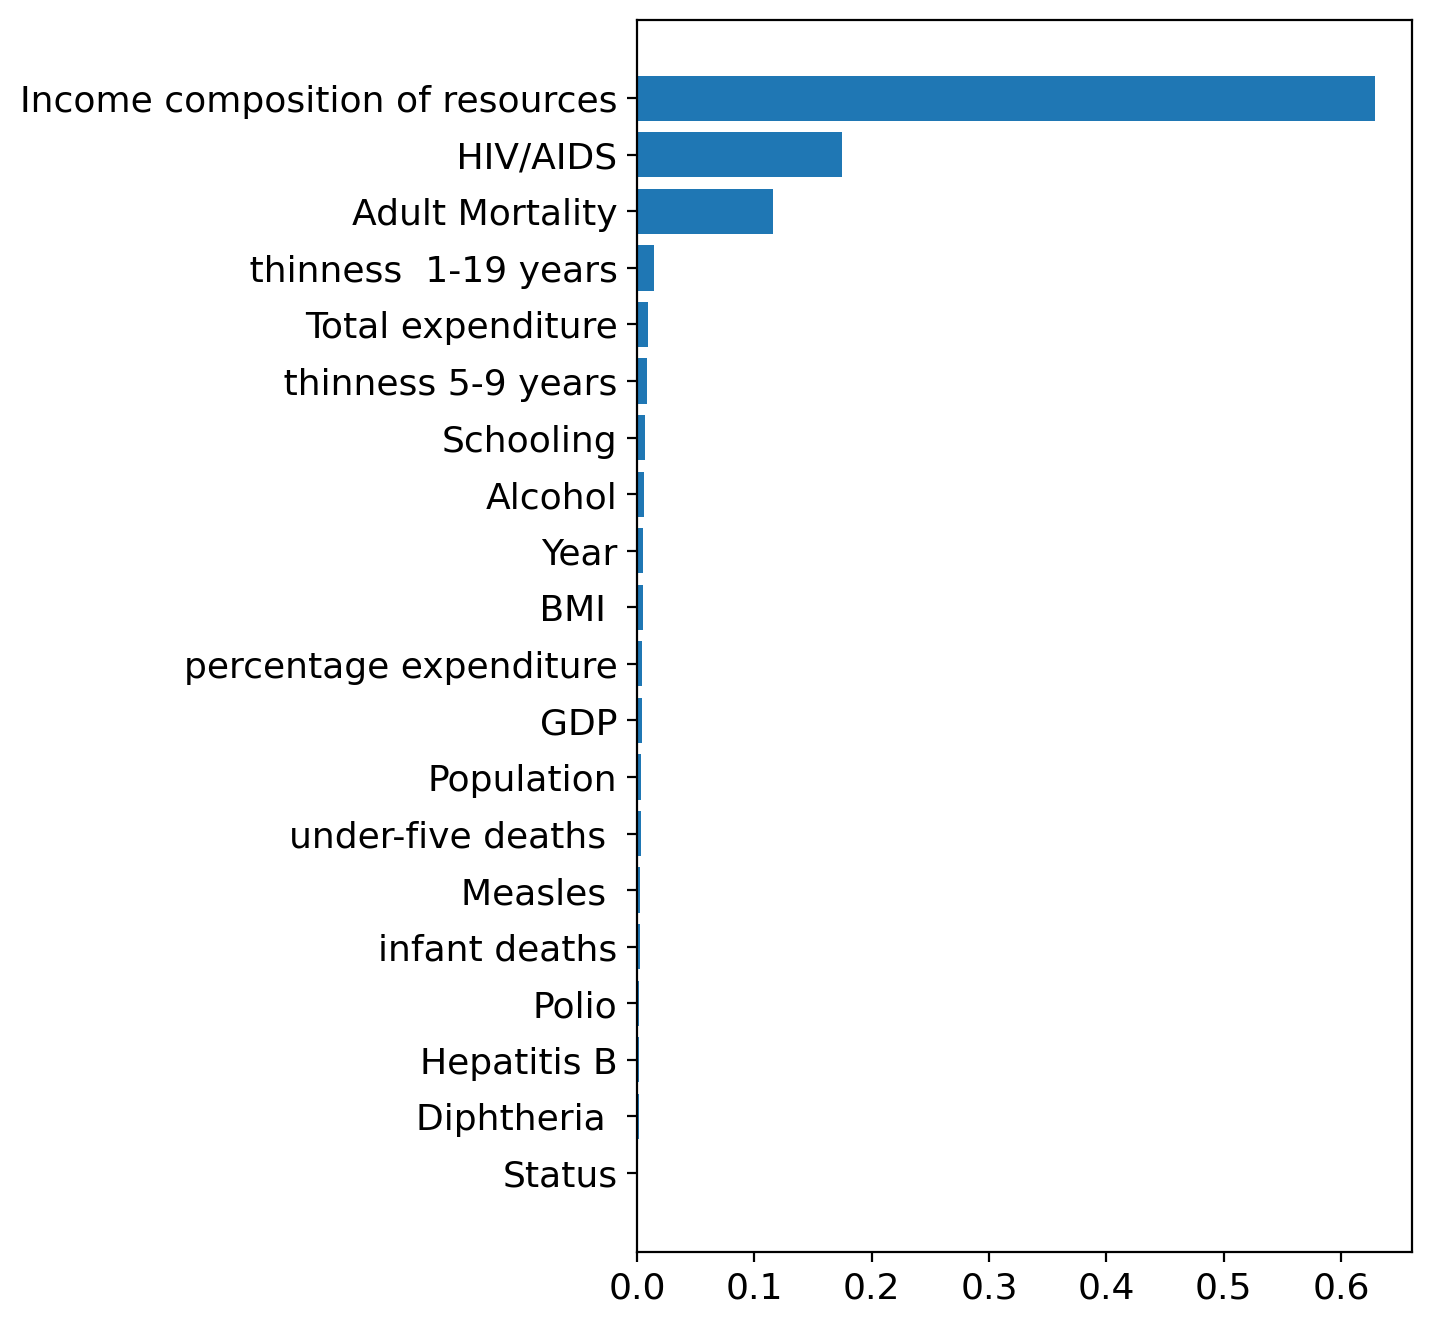

In [24]:
## 랜덤 포레스트 모델 성능 확인

rfr = RandomForestRegressor(max_depth=13)
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)
show_reg_result(y_test,y_pred)

plot_feature_weight(X.columns, rfr.feature_importances_)

# 부스팅 (LightGBM)

- 설치가 안되어 있는 경우 아래와 같이 설치해야 함
- !conda install lightgbm -y

depth:  19 , R-squared:  0.952


<Axes: xlabel='depth'>

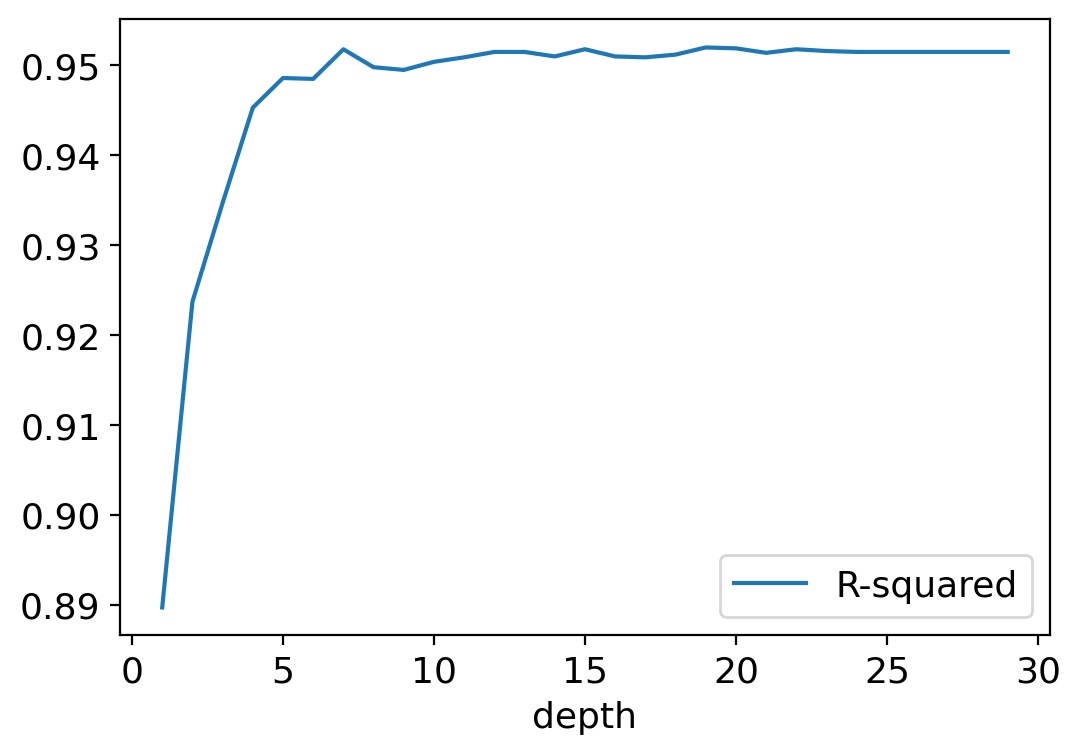

In [25]:
# 최적의 트리 깊이 (max_depth)를 실험으로 찾는다
res = []
for depth in range(1,30):
    lgbm_r = LGBMRegressor(max_depth=depth, num_leaves=32) 
    lgbm_r.fit(X_train, y_train, eval_set=(X_test, y_test), 
           early_stopping_rounds=5, verbose=False)
    res.append((depth, lgbm_r.score(X_test, y_test).round(4))) 

df_res = pd.DataFrame(res, columns=['depth','R-squared']).set_index('depth')
print('depth: ',df_res.idxmax()[0], ', R-squared: ',df_res.max()[0])
df_res.plot()

Max Error:  12.862
Mean Absolute Error:  1.221
Root Mean Squared Error:  1.955
R-Squared:  0.952


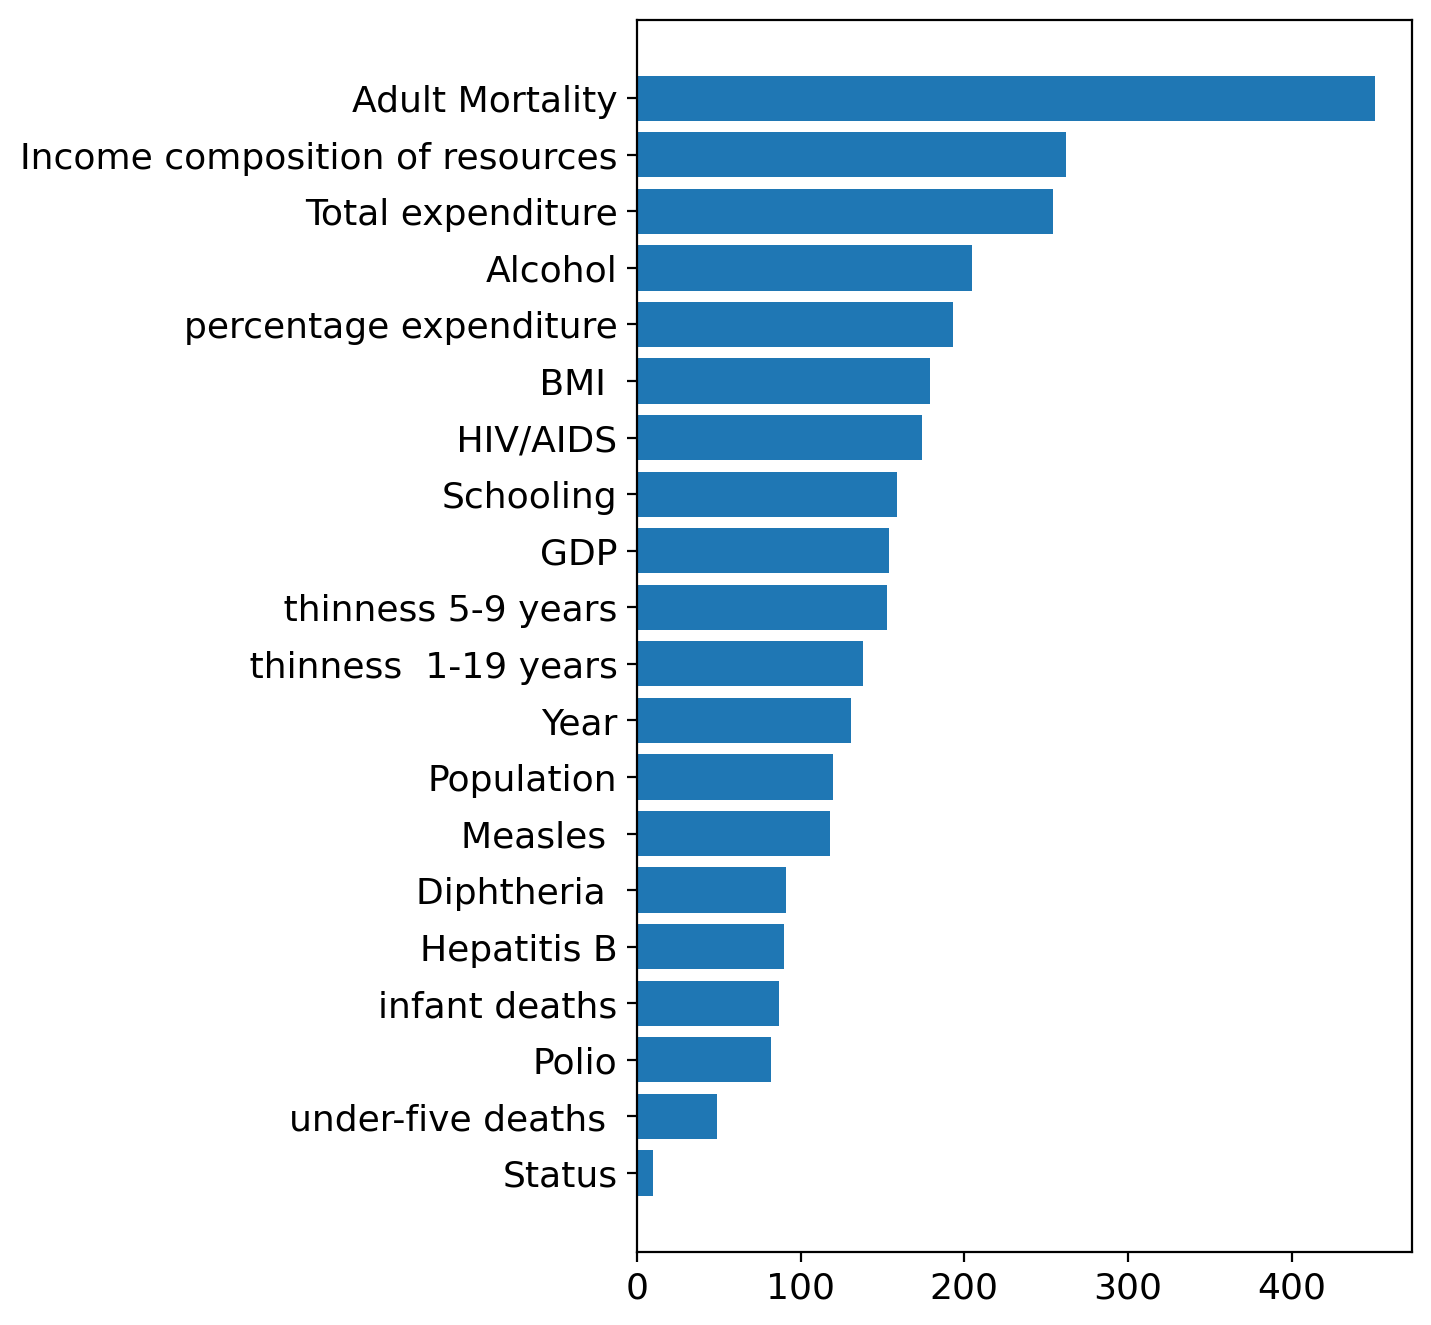

In [26]:
## 부스팅 모델 성능 확인

lgbm_r = LGBMRegressor(max_depth=19, num_leaves=32)
lgbm_r.fit(X_train, y_train, eval_set=(X_test, y_test), 
           early_stopping_rounds=5, verbose=False)
y_pred = lgbm_r.predict(X_test)
show_reg_result(y_test,y_pred)

plot_feature_weight(X.columns, lgbm_r.feature_importances_)

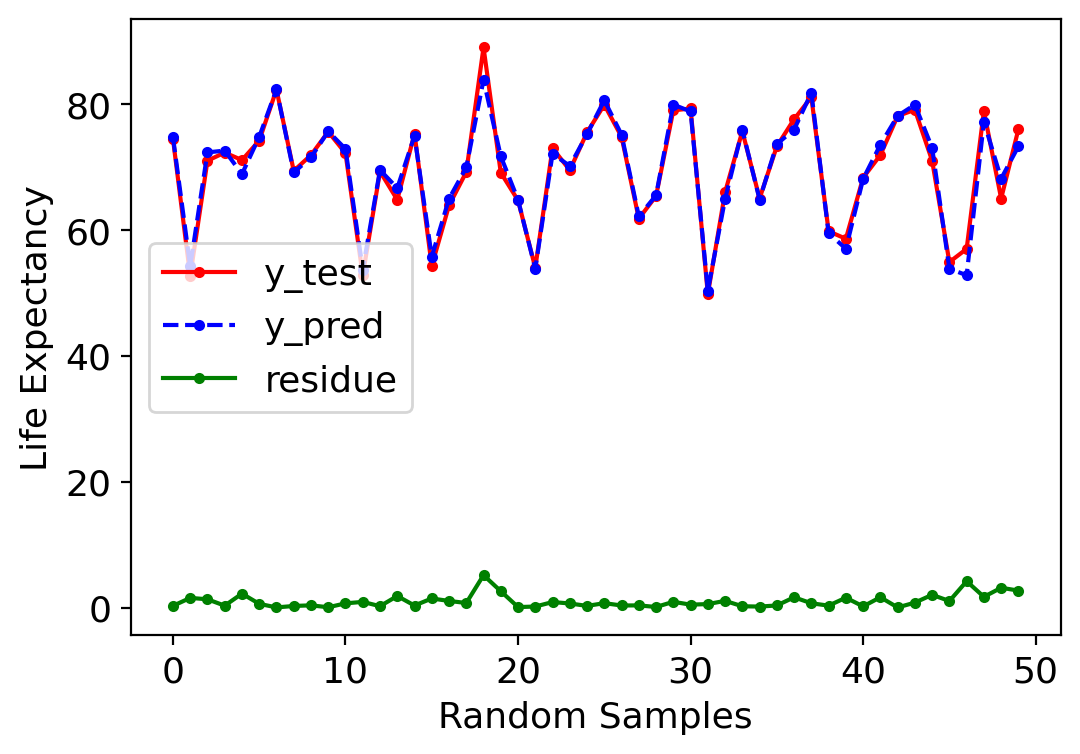

In [30]:
## 회귀 예측과 실제값 샘플 비교하기

def plot_reg_result(y_test, y_pred, N=50):
    y_test = y_test.values
    plt.plot(y_test[:N], 'r.-', label='y_test')
    plt.plot(y_pred[:N], 'b.--', label='y_pred')
    plt.plot(np.abs(y_pred[:N]-y_test[:N]), 'g.-', label='residue')
    plt.legend()
    plt.xlabel("Random Samples")
    plt.ylabel("Life Expectancy")
    plt.show()

y_pred = lgbm_r.predict(X_test)
plot_reg_result(y_test, y_pred)

# 목적변수와의 상관계수 보기

In [29]:
# 데이터프레임 X의 각 컬럼과 목적변수와의 상관계수 보기
correlations = X.corrwith(y)
correlations.sort_values().to_frame()

,0
Adult Mortality,-0.702523
HIV/AIDS,-0.592236
thinness 1-19 years,-0.457838
thinness 5-9 years,-0.457508
under-five deaths,-0.192265
infant deaths,-0.169074
Measles,-0.068881
Population,-0.022305
Year,0.050771
Total expenditure,0.174718


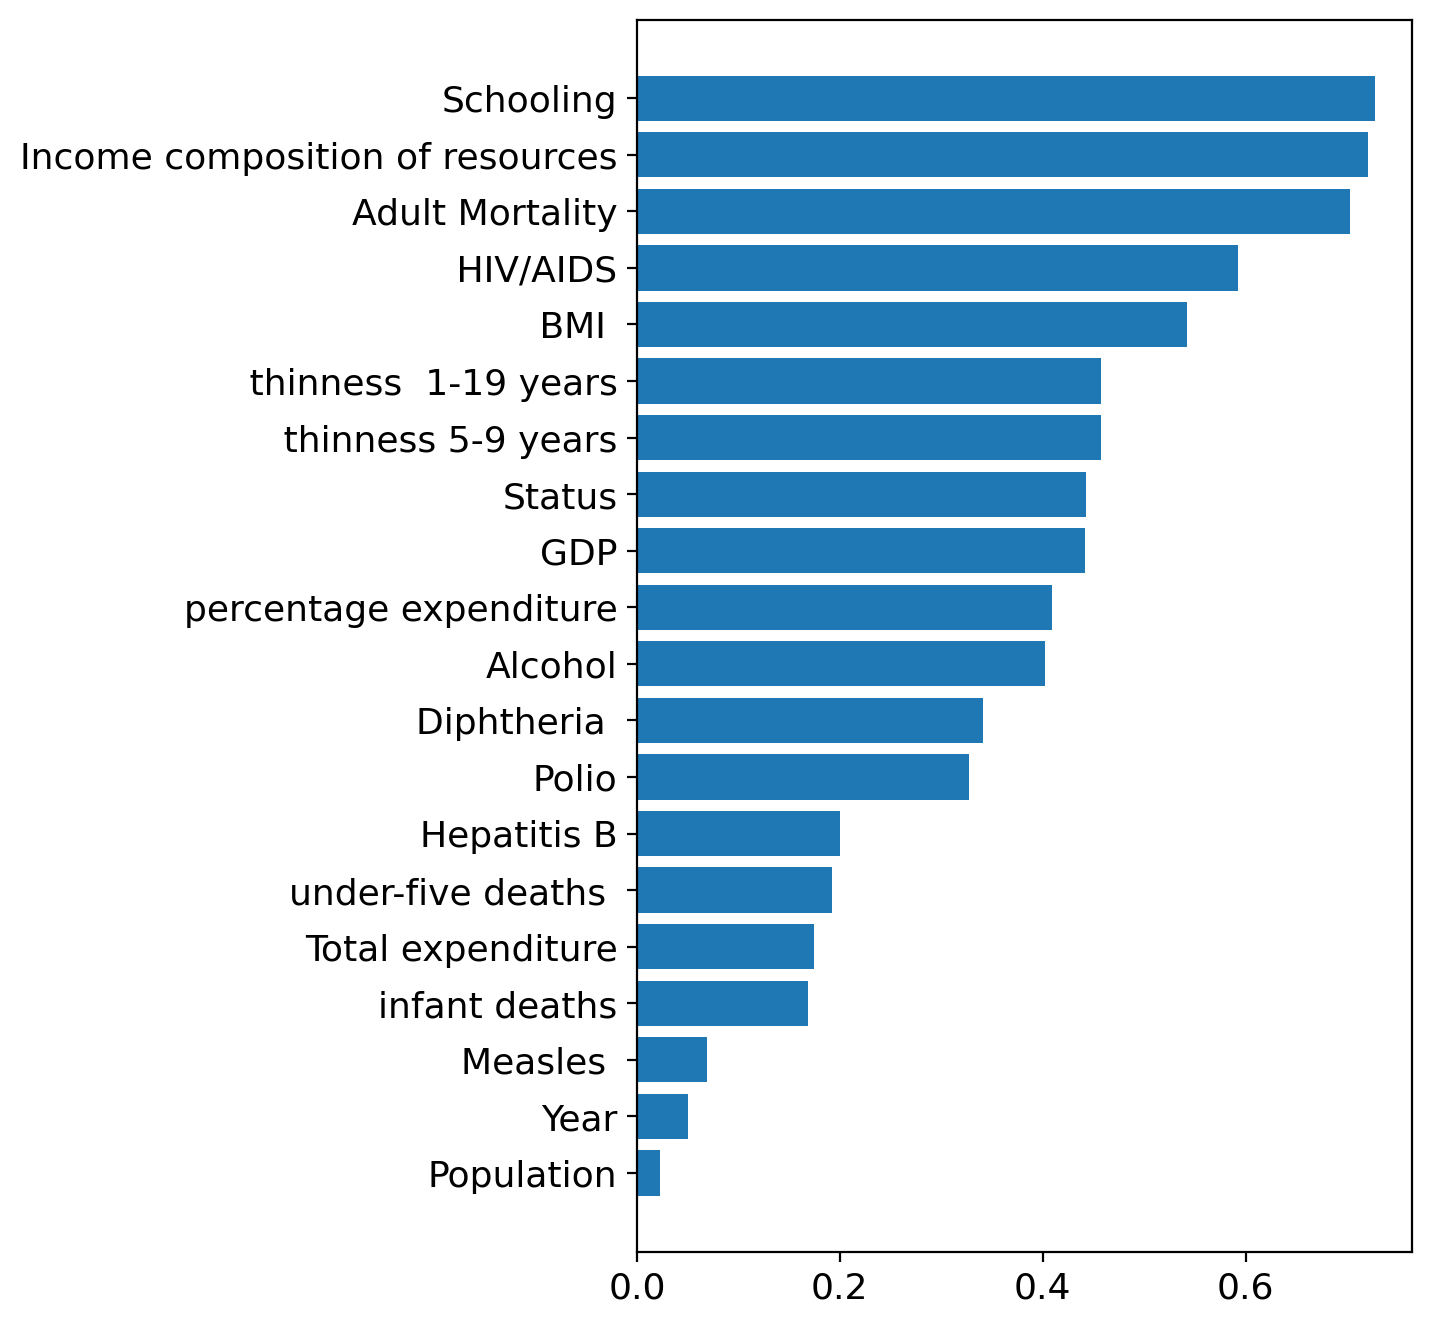

In [32]:
plot_feature_weight(X.columns, np.abs(correlations))

# (실습) 가장 성능이 좋은 3개의 특성 선택하기
- 임의로 3개의 특성을 선택했을 때 성능이 가능 좋은 경우가 언제인지 찾아보시오
- 선형모델 가중치, 특성중요도, 상관계수 등을 참고하여 임의의 특성을 고르고 성능을 비교하시오
- 선형모델, 랜덤 포레스트, 부스팅 모델의 성능을 비교하시오

In [31]:
X.columns

Index([' BMI ', ' HIV/AIDS', ' thinness  1-19 years', ' thinness 5-9 years',
       'Adult Mortality', 'Alcohol', 'Diphtheria ', 'GDP', 'Hepatitis B',
       'Income composition of resources', 'Measles ', 'Polio', 'Population',
       'Schooling', 'Status', 'Total expenditure', 'Year', 'infant deaths',
       'percentage expenditure', 'under-five deaths '],
      dtype='object')

In [33]:
# 세가지 경우에 대해서(선형계수, 특성중요도, 상관계수) 값이 큰 순으로 특성을 3개씩 선택했다.
feature_linear = ['Schooling','Adult Mortality',' HIV/AIDS']
feature_rfr = ['Income composition of resources','Adult Mortality',' HIV/AIDS']
feature_boost = ['Adult Mortality','Income composition of resources', 'Total expenditure']

result = []
for feature in [feature_linear, feature_rfr, feature_boost]:
    X_ft = X[feature]
    
    # 선형모델은 스케일링 필요함
    X_ft_sc = scaler.fit_transform(X_ft)
    X_train, X_test, y_train, y_test = train_test_split(X_ft_sc, y)
    lin.fit(X_train, y_train)
    rfr.fit(X_train, y_train)
    lgbm_r.fit(X_train, y_train)

    result.append((feature,
                 lin.score(X_test, y_test).round(3),
                 rfr.score(X_test, y_test).round(3),
                 lgbm_r.score(X_test, y_test).round(3)))
                  

In [34]:
result

[(['Schooling', 'Adult Mortality', ' HIV/AIDS'], 0.779, 0.928, 0.924),
 (['Income composition of resources', 'Adult Mortality', ' HIV/AIDS'],
  0.773,
  0.945,
  0.939),
 (['Adult Mortality', 'Income composition of resources', 'Total expenditure'],
  0.728,
  0.936,
  0.935)]

In [35]:
pd.DataFrame(result, columns = ['featuers', 'Linear','Random Forest', "LGBM"] )

,featuers,Linear,Random Forest,LGBM
0,"[Schooling, Adult Mortality, HIV/AIDS]",0.779,0.928,0.924
1,"[Income composition of resources, Adult Mortal...",0.773,0.945,0.939
2,"[Adult Mortality, Income composition of resour...",0.728,0.936,0.935
